In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from mplsoccer.pitch import Pitch
import xml.etree.ElementTree as et
import numpy as np
from matplotlib.colors import to_rgba
import os
from pathlib import Path

In [3]:
base_dir = os.path.join('',Path(os.getcwd()).parents[1])
data_dir = os.path.join(base_dir, 'Data/EventingEibar')
file = '07-02-2021--Spain--Primera-DivisionOsasuna-2-1-Eibar20210306-3162-1isaph3.xml'
file = os.path.join(data_dir,file)

In [4]:
tree = et.parse(file)
root = tree.getroot()

node_names = ['ID', 'start', 'end', 'code', 'pos_x', 'pos_y']
node_names_full = []
matrix = []
for node in root.iter('ALL_INSTANCES'):
    for instance in node.iter('instance'):
        if instance.find('code').text!='Empezar marca de tiempo':
            row=[]
            for node_name in node_names:
                row.append(instance.find(node_name).text)
            for label in instance.iter('label'):
                row.append(label.find('text').text)
                if label.find('group').text not in node_names_full and label.find('group').text not in node_names:
                    node_names_full.append(label.find('group').text)
            matrix.append(row)

In [5]:
descanso = 45*60

In [6]:
df = pd.DataFrame(data = matrix,columns = node_names+node_names_full)
df.head()

,ID,start,end,code,pos_x,pos_y,Equipo,Accion,Medio
0,1,0,18.41,9. Sergi Enrich,52.5,34.1,Eibar,Pases precisos,1ª parte
1,2,0,18.41,9. Sergi Enrich,52.5,34.1,Eibar,Ataques posicionales,1ª parte
2,3,1.23,21.23,3. Pedro Bigas,34.4,38.4,Eibar,Ataques posicionales,1ª parte
3,4,1.23,21.23,3. Pedro Bigas,34.4,38.4,Eibar,Pases (inefectivo),1ª parte
4,5,4.21,24.21,5. David Garcia Zubiria,25.9,60.3,Osasuna,Ataques posicionales,1ª parte


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4028 entries, 0 to 4027
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      4028 non-null   object
 1   start   4028 non-null   object
 2   end     4028 non-null   object
 3   code    4028 non-null   object
 4   pos_x   4028 non-null   object
 5   pos_y   4028 non-null   object
 6   Equipo  4028 non-null   object
 7   Accion  4028 non-null   object
 8   Medio   4028 non-null   object
dtypes: object(9)
memory usage: 283.3+ KB


In [8]:
for i in ['ID','start','end','pos_x','pos_y']:
    df[i] = pd.to_numeric(df[i])
    
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4028 entries, 0 to 4027
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      4028 non-null   int64  
 1   start   4028 non-null   float64
 2   end     4028 non-null   float64
 3   code    4028 non-null   object 
 4   pos_x   4028 non-null   float64
 5   pos_y   4028 non-null   float64
 6   Equipo  4028 non-null   object 
 7   Accion  4028 non-null   object 
 8   Medio   4028 non-null   object 
dtypes: float64(4), int64(1), object(4)
memory usage: 283.3+ KB


In [9]:
df.Accion.value_counts()

Ataques posicionales                     1303
Pases precisos                            689
Contraataques                             256
Pases (inefectivo)                        207
Disputas (perdio)                         203
Disputas (vencio)                         184
Perdidas                                  160
Rechaces                                  158
Interceptaciones                          122
Disputas por arriba (perdio)               93
Disputas por arriba (vencio)               93
Pases al area                              75
Rechaces (en campo contrario)              56
Tiros libres a favor                       46
Corners                                    40
Entradas (Acciones con exito)              29
Conduccion                                 26
Perdidas (en campo contrario)              24
Faltas                                     21
Interceptaciones (en campo contrario)      21
Centros (inefectivo)                       21
Regates (Acciones con exito)      

In [10]:
df.rename({'Medio':'Half','code':'Player'},axis=1,inplace=True)

In [11]:
tit = list(df[(df['Half'].str.contains('1')) & (df.Equipo=='Eibar')]['Player'].unique())
tit

['9. Sergi Enrich',
 '3. Pedro Bigas',
 '23. Arbilla',
 '17. Kike',
 '4. Paulo Oliveira',
 '18. Recio',
 '10. Edu Exposito',
 '12. Yoshinori Muto',
 '25. Bryan Gil Salvatierra',
 '11. Rafa',
 '1. Marko Dmitrovic']

### EJERCICIO 1: Red de Pases

In [12]:
df_pases = df[(df['Accion']=='Pases precisos') & (df.Equipo=='Eibar')]
df_pases.shape[0]

317

In [13]:
df['Rec_x'] = 0
df['Rec_y'] = 0
df['Rec_Jugador'] = ''
df['Rec_Outcome'] = ''

for i,j in df_pases.iterrows():
    player = df_pases.loc[i,'Player']
    team = df_pases.loc[i,'Equipo']
    if j['Accion'] == 'Pases precisos':
        for k,h in df[i:].iterrows():
            if player!=h['Player'] and team==h['Equipo']:
                df_pases.loc[i,'Rec_x']= df.loc[k,'pos_x']
                df_pases.loc[i,'Rec_y']= df.loc[k,'pos_y']
                df_pases.loc[i,'Rec_Jugador']= df.loc[k,'Player']
                if team==h['Equipo']:
                    df_pases.loc[i,'Rec_Outcome']= 'Propio'
                else:
                    df_pases.loc[i,'Rec_Outcome']= 'Rival'
                break

C:\Users\aleex\AppData\Local\Temp/ipykernel_4888/3319457576.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pases.loc[i,'Rec_x']= df.loc[k,'pos_x']
C:\Users\aleex\AppData\Local\Temp/ipykernel_4888/3319457576.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pases.loc[i,'Rec_y']= df.loc[k,'pos_y']
C:\Users\aleex\AppData\Local\Temp/ipykernel_4888/3319457576.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [14]:
df_pases.head(25)

,ID,start,end,Player,pos_x,pos_y,Equipo,Accion,Half,Rec_x,Rec_y,Rec_Jugador,Rec_Outcome
0,1,0.00,18.41,9. Sergi Enrich,52.5,34.1,Eibar,Pases precisos,1ª parte,34.4,38.4,3. Pedro Bigas,Propio
9,10,6.28,26.28,23. Arbilla,64.7,10.5,Eibar,Pases precisos,1ª parte,78.3,13.6,17. Kike,Propio
60,62,45.54,65.54,4. Paulo Oliveira,40.1,13.7,Eibar,Pases precisos,1ª parte,52.0,14.1,18. Recio,Propio
68,70,48.79,68.79,10. Edu Exposito,43.8,16.8,Eibar,Pases precisos,1ª parte,59.8,11.3,9. Sergi Enrich,Propio
72,74,50.86,70.86,9. Sergi Enrich,59.8,11.3,Eibar,Pases precisos,1ª parte,92.0,18.8,12. Yoshinori Muto,Propio
157,159,178.50,198.50,18. Recio,57.4,18.8,Eibar,Pases precisos,1ª parte,72.2,22.5,17. Kike,Propio
186,188,201.87,221.87,23. Arbilla,14.9,6.6,Eibar,Pases precisos,1ª parte,76.7,15.0,17. Kike,Propio
208,210,217.56,237.56,25. Bryan Gil Salvatierra,48.0,50.5,Eibar,Pases precisos,1ª parte,57.8,39.2,9. Sergi Enrich,Propio
220,222,240.35,260.35,18. Recio,37.2,34.7,Eibar,Pases precisos,1ª parte,38.9,54.9,3. Pedro Bigas,Propio
222,224,243.27,263.27,3. Pedro Bigas,38.9,54.9,Eibar,Pases precisos,1ª parte,98.4,33.9,25. Bryan Gil Salvatierra,Propio


In [15]:
df_pases.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 317 entries, 0 to 3991
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           317 non-null    int64  
 1   start        317 non-null    float64
 2   end          317 non-null    float64
 3   Player       317 non-null    object 
 4   pos_x        317 non-null    float64
 5   pos_y        317 non-null    float64
 6   Equipo       317 non-null    object 
 7   Accion       317 non-null    object 
 8   Half         317 non-null    object 
 9   Rec_x        317 non-null    float64
 10  Rec_y        317 non-null    float64
 11  Rec_Jugador  317 non-null    object 
 12  Rec_Outcome  317 non-null    object 
dtypes: float64(6), int64(1), object(6)
memory usage: 42.8+ KB


Una vez tenemos registrados todos los pases exitosos + receptor y posiciones de salida y llegada,debemos, en primer lugar, calcular la posición media de pases de cada jugador y el nº de pases realizados. El objetivo es poder situar a cada uno de ellos en el campo y establecer un tamaño para el scatter en función de su participación.

In [16]:
df_pos= df_pases.groupby('Player').agg({'pos_x':['mean'],'pos_y':['mean'],'Player':['count']})
df_pos.columns = ['_'.join(col) for col in df_pos.columns.values if col!='Player']
df_pos = df_pos.reset_index()
df_pos = df_pos[df_pos.Player.isin(tit)]
df_pos.head()

,Player,pos_x_mean,pos_y_mean,Player_count
0,1. Marko Dmitrovic,11.642857,36.028571,21
1,10. Edu Exposito,58.839394,33.636364,33
2,11. Rafa,54.053659,62.282927,41
3,12. Yoshinori Muto,76.171429,20.985714,14
4,17. Kike,74.486957,41.356522,23


In [17]:
df_rec= df_pases.groupby('Rec_Jugador').agg({'Rec_x':['mean'],'Rec_y':['mean'],'Player':['count']})
df_rec.columns = ['_'.join(col) for col in df_rec.columns.values]
df_rec = df_rec.reset_index()
df_rec.head()

,Rec_Jugador,Rec_x_mean,Rec_y_mean,Player_count
0,1. Marko Dmitrovic,9.400000,36.808333,12
1,10. Edu Exposito,57.752941,38.661765,34
2,11. Rafa,60.282609,61.573913,23
3,12. Yoshinori Muto,78.583333,26.641667,24
4,17. Kike,70.677551,37.873469,49


El siguiente paso consiste en agrupar el dataframe original y extraer el conteo de pases entre un jugador y otro

In [18]:
df_rel = df_pases.groupby(by=['Player','Rec_Jugador'],as_index=False)['Accion'].count()
df_rel.rename({'Accion':'count'},axis=1,inplace=True)
df_rel.head()

,Player,Rec_Jugador,count
0,1. Marko Dmitrovic,11. Rafa,1
1,1. Marko Dmitrovic,12. Yoshinori Muto,2
2,1. Marko Dmitrovic,17. Kike,10
3,1. Marko Dmitrovic,3. Pedro Bigas,2
4,1. Marko Dmitrovic,4. Paulo Oliveira,2


Ahora debemos de calcular el total de pases por cada par de jugadores

In [19]:
df_rel['Flag'] = 0
df_aux = df_rel

matrix = []

for i,j in df_rel.iterrows():
    for k,h in df_aux.iterrows():
        if df_rel.loc[i,'Flag']==0:
            matrix.append([j['Player'],j['Rec_Jugador'],j['count']])
            df_rel.loc[i,'Flag']=1
        elif (j['Player']==h['Rec_Jugador']) and (j['Rec_Jugador']==h['Player']) and (df_rel.loc[k,'Flag']==0):
            matrix.append([h['Rec_Jugador'],h['Player'],h['count']])
            df_rel.loc[k,'Flag']=1
            
df_rel

,Player,Rec_Jugador,count,Flag
0,1. Marko Dmitrovic,11. Rafa,1,1
1,1. Marko Dmitrovic,12. Yoshinori Muto,2,1
2,1. Marko Dmitrovic,17. Kike,10,1
3,1. Marko Dmitrovic,3. Pedro Bigas,2,1
4,1. Marko Dmitrovic,4. Paulo Oliveira,2,1
...,...,...,...,...
101,9. Sergi Enrich,18. Recio,1,1
102,9. Sergi Enrich,23. Arbilla,1,1
103,9. Sergi Enrich,25. Bryan Gil Salvatierra,3,1
104,9. Sergi Enrich,3. Pedro Bigas,1,1


In [20]:
df_rel = pd.DataFrame(data=matrix,columns=['Player','Rec_Jugador','count'])
df_rel.head(20)

,Player,Rec_Jugador,count
0,1. Marko Dmitrovic,11. Rafa,1
1,1. Marko Dmitrovic,11. Rafa,3
2,1. Marko Dmitrovic,12. Yoshinori Muto,2
3,1. Marko Dmitrovic,17. Kike,10
4,1. Marko Dmitrovic,3. Pedro Bigas,2
5,1. Marko Dmitrovic,3. Pedro Bigas,2
6,1. Marko Dmitrovic,4. Paulo Oliveira,2
7,1. Marko Dmitrovic,4. Paulo Oliveira,1
8,1. Marko Dmitrovic,6. Sergio Alvarez,1
9,1. Marko Dmitrovic,9. Sergi Enrich,3


In [21]:
df_rel[df_rel.Player.str.contains('11.')]

,Player,Rec_Jugador,count
28,11. Rafa,12. Yoshinori Muto,4
29,11. Rafa,17. Kike,10
30,11. Rafa,17. Kike,1
31,11. Rafa,18. Recio,3
32,11. Rafa,18. Recio,1
33,11. Rafa,2. Esteban Rodrigo Burgos,1
34,11. Rafa,2. Esteban Rodrigo Burgos,3
35,11. Rafa,22. Alejandro Pozo,1
36,11. Rafa,25. Bryan Gil Salvatierra,8
37,11. Rafa,25. Bryan Gil Salvatierra,4


In [22]:
df_rel = df_rel.groupby(by=['Player','Rec_Jugador'],as_index=False)['count'].sum()
df_rel.rename({'count':'sum'},axis=1,inplace=True)
df_rel.head()

,Player,Rec_Jugador,sum
0,1. Marko Dmitrovic,11. Rafa,4
1,1. Marko Dmitrovic,12. Yoshinori Muto,2
2,1. Marko Dmitrovic,17. Kike,10
3,1. Marko Dmitrovic,3. Pedro Bigas,4
4,1. Marko Dmitrovic,4. Paulo Oliveira,3


In [23]:
df_rel.shape[0]

66

In [24]:
df_merged = pd.merge(df_rel,df_pos,how='left',on='Player')
df_merged.columns = ['Passer','Receiver','Passes','passer_x','passer_y','count_passer']
df_merged = pd.merge(df_merged,df_pos,how='left',left_on='Receiver',right_on='Player')
df_merged.head()

,Passer,Receiver,Passes,passer_x,passer_y,count_passer,Player,pos_x_mean,pos_y_mean,Player_count
0,1. Marko Dmitrovic,11. Rafa,4,11.642857,36.028571,21.0,11. Rafa,54.053659,62.282927,41.0
1,1. Marko Dmitrovic,12. Yoshinori Muto,2,11.642857,36.028571,21.0,12. Yoshinori Muto,76.171429,20.985714,14.0
2,1. Marko Dmitrovic,17. Kike,10,11.642857,36.028571,21.0,17. Kike,74.486957,41.356522,23.0
3,1. Marko Dmitrovic,3. Pedro Bigas,4,11.642857,36.028571,21.0,3. Pedro Bigas,40.554167,50.004167,24.0
4,1. Marko Dmitrovic,4. Paulo Oliveira,3,11.642857,36.028571,21.0,4. Paulo Oliveira,37.614815,24.788889,27.0


In [25]:
df_merged.drop('Player',axis=1,inplace=True)
df_merged.rename({'pos_x_mean':'receiver_x','pos_y_mean':'receiver_y','Player_count':'count_receiver'},
                inplace=True,axis=1)
df_merged.head()

,Passer,Receiver,Passes,passer_x,passer_y,count_passer,receiver_x,receiver_y,count_receiver
0,1. Marko Dmitrovic,11. Rafa,4,11.642857,36.028571,21.0,54.053659,62.282927,41.0
1,1. Marko Dmitrovic,12. Yoshinori Muto,2,11.642857,36.028571,21.0,76.171429,20.985714,14.0
2,1. Marko Dmitrovic,17. Kike,10,11.642857,36.028571,21.0,74.486957,41.356522,23.0
3,1. Marko Dmitrovic,3. Pedro Bigas,4,11.642857,36.028571,21.0,40.554167,50.004167,24.0
4,1. Marko Dmitrovic,4. Paulo Oliveira,3,11.642857,36.028571,21.0,37.614815,24.788889,27.0


In [26]:
df_pos.head()

,Player,pos_x_mean,pos_y_mean,Player_count
0,1. Marko Dmitrovic,11.642857,36.028571,21
1,10. Edu Exposito,58.839394,33.636364,33
2,11. Rafa,54.053659,62.282927,41
3,12. Yoshinori Muto,76.171429,20.985714,14
4,17. Kike,74.486957,41.356522,23


In [27]:
max_line_width = 18
max_marker_size = 3000
df_merged['width'] = df_merged.Passes / df_merged.Passes.max() * max_line_width
df_pos['marker_size'] = (df_pos['Player_count']
                                         / df_pos['Player_count'].max() * max_marker_size)

In [28]:
min_transparency = 0.3
color = np.array(to_rgba('white'))
color = np.tile(color, (df_merged.shape[0], 1))
c_transparency = df_merged.Passes / df_merged.Passes.max()
c_transparency = (c_transparency * (1 - min_transparency)) + min_transparency
color[:, 3] = c_transparency

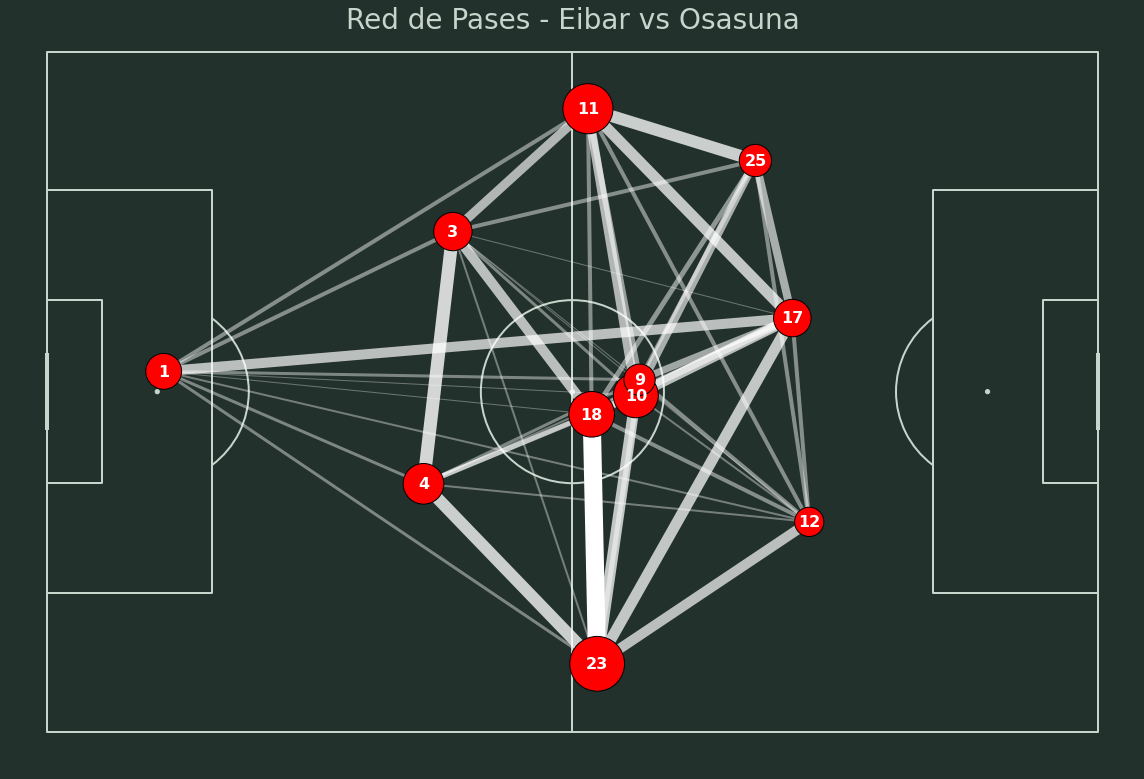

In [29]:
pitch = Pitch(pitch_type='uefa',
              pitch_color='#22312b', line_color='#c7d5cc')
fig, ax = pitch.draw(figsize=(16, 11))
pass_lines = pitch.lines(df_merged.passer_x, df_merged.passer_y,
                         df_merged.receiver_x, df_merged.receiver_y, lw=df_merged.width,
                         color=color, zorder=1, ax=ax)
pass_nodes = pitch.scatter(df_pos.pos_x_mean, df_pos.pos_y_mean, s=df_pos.marker_size,
                           color='red', edgecolors='black', linewidth=1, alpha=1, ax=ax)
for i, j in df_pos.iterrows():
    dorsal = j['Player'].split('.')
    d = dorsal[0]
    pitch.annotate(d, xy=(j['pos_x_mean'], j['pos_y_mean']), c='white', va='center', ha='center', size=16, weight='bold', ax=ax)
title = ax.set_title("Red de Pases - {} vs {}".format(df_pases.Equipo.head(1).values[0], 'Osasuna'), size=28, y=0.97, color='#c7d5cc')
fig.set_facecolor("#22312b")